# Evaluate the question matcher using the existing harmonisation tool as a gold standard



In [1]:
import sys

sys.path.append("../front_end")


import bz2
import os
import pickle as pkl
import re
import sys
from nltk.corpus import stopwords
from langdetect import detect
import numpy as np

import pandas as pd

from utils.pt_en_dict import pt_en_map
from utils.spacy_wrapper import get_spacy_model


In [2]:
INPUT_FILE = "../data/Final harmonised item tool EM.xlsx"


In [3]:
initial_number_regex = re.compile(r'^\d+\.')

In [4]:
question_to_category_for_gold_standard = {}

# TODO: do Adulthood separately
question_dfs = []
for sheet_name in ("Childhood",):
    df = pd.read_excel(INPUT_FILE, sheet_name=sheet_name)

    if sheet_name == "Adulthood":
        labels_in_this_sheet = ["Adulthood"] * len(df)
        df = df[df.columns[4:]]
    else:
        labels_in_this_sheet = list(df["Developmental period"])
        df = df[df.columns[5:]]
        

    for idx in range(0, len(df)):
        if idx > 10:
            break
        questions = {}
        
        q_to_c = {}
        ctr = 0
        
        for j in range(len(df.columns)):
            col_name = df.columns[j]
            text = df[col_name].iloc[idx]
            if type(text) is str and len(text) > 1:
                for q in text.split("/"):
                    q = q.strip()
                    
                    m = initial_number_regex.match(q)
                    if m:
                        number = int(re.sub(r'\.', '', m.group()))
                        questions[number] = initial_number_regex.sub("", q).strip()
                        q_to_c[number] = col_name.strip()
                    elif len(q) > 1:
                        number = ctr
                        questions[number] = q
                        q_to_c[number] = col_name.strip()
                        ctr += 1
        
        if len(questions) > 0:
            question_df = pd.DataFrame({"number":sorted(questions)})
            for j in range(len(question_df)):
                q_no = question_df.number.iloc[j]
                question_to_category_for_gold_standard[(len(question_dfs), j)] = q_to_c[q_no]


            question_df.attrs["language"] = "en"
            question_df["question"] = question_df.number.apply(lambda n : questions[n])
        
        
        
        
            question_dfs.append(question_df)

In [5]:
category_to_question_groups_for_gold_standard = {}
for key, value in question_to_category_for_gold_standard.items():
    category_to_question_groups_for_gold_standard.setdefault(value, [])
    category_to_question_groups_for_gold_standard[value].append(key)

In [6]:
gold_standard = []
for key, groups in category_to_question_groups_for_gold_standard.items():
    if len(groups) > 1:
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                gold_standard.append((groups[i][0], groups[i][1], groups[j][0], groups[j][1]))

In [7]:
gold_standard_dict = {}
for i in range(len(question_dfs)):
    for idx in range(len(question_dfs[i])):
        for j in range(i + 1, len(question_dfs)):
            for jdx in range(len(question_dfs[j])):
                gold_standard_dict[(i, idx, j, jdx)] = 0
for g in gold_standard:
    gold_standard_dict[g] = 1

In [8]:
len(gold_standard_dict)

30007

In [9]:
len(question_dfs)

11

In [10]:
from utils.question_matcher_spacy import QuestionMatcherSpacy

In [11]:
qm = QuestionMatcherSpacy()

In [12]:
matches = qm.match_questions(question_dfs)

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/projects_client/wellcome/harmony/notebooks/../front_end/utils/question_matcher_spacy.py:33: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  pairwise_similarity = transforms[i].iloc[ii].similarity(transforms[j].iloc[jj])


In [13]:
matches_pruned = [m for m in matches if matches[m] > 0.5]

print ("Number of matches found", len(set(matches_pruned)))
print ("Number of matches in gold standard", len(set(gold_standard)))
print ("Number of matches found which were in gold standard",len(set(matches_pruned).intersection(set(gold_standard))))
print ("Number of matches found which were not in standard",len(set(matches_pruned).difference(set(gold_standard))))

print ("Jaccard", len(set(matches_pruned).intersection(set(gold_standard))) / len(set(matches_pruned).union(set(gold_standard))))

Number of matches found 1543
Number of matches in gold standard 2102
Number of matches found which were in gold standard 455
Number of matches found which were not in standard 1088
Jaccard 0.1426332288401254


In [14]:
for m in matches_pruned:
    if m in gold_standard:
        print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]])

Cries Easily = She cries easily
Tries to be Fair in Games = Is kind to younger children
Is Affectionate to Family Members = Is kind to younger children
Is Kind to Young Children = Is kind to younger children
Is Kind to Animals = Is kind to younger children
Is Considerate for Others = Is considerate of other people's feelings
Is Considerate for Others = Is kind to younger children
Is Restless and Doesnt keep still = Is restless, overactive, cannot stay still for long
Is Restless and Doesnt keep still = Is constantly fidgeting or squirming
Bullies Other Children = Bullies other children
Bites or Kicks Other Children = Bullies other children
Is Irritable = Irritable. Is quick to fly off the handle
Is Disobedient = Is often disobedient
Worries about Many Things = Often worried, worries about many things
Twitches or Has Tics = Has twitches, mannerisms or tics of the face or body
Twitches or Has Tics = Frequently bites nails or fingers
Bites Nails or Fingers = Has twitches, mannerisms or tic

In [15]:
for m in matches_pruned:
    if m not in gold_standard:
        print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]])

Destroys Own Others Belongings = She prefers quiet inactive games to more active ones
Worries about Many Things = She prefers quiet inactive games to more active ones
Tries to be Fair in Games = She likes to be with people
Tries to Stop Quarrels = She likes to be with people
Is Considerate for Others = She likes to be with people
Stares into Space = She takes a long time to warm up to strangers
Gets on With Other Children = She takes a long time to warm up to strangers
Fights With Other Children = Gets on better with adults than with other children
Is Irritable = Is restless, overactive, cannot stay still for long
Is Irritable = Is rather solitary, tends to play alone
Is Irritable = Is nervous or clingy in new situations, easily loses confidence
Is Irritable = Is kind to younger children
Is Irritable = Has many fears, is easily scared
Is Disobedient = Is rather solitary, tends to play alone
Is Disobedient = Is kind to younger children
Is Disobedient = Has many fears, is easily scared
I

In [16]:
for m in gold_standard:
    if m not in matches:
        print (question_dfs[m[0]].question.iloc[m[1]], "=", question_dfs[m[2]].question.iloc[m[3]])

Child appears miserable, unhappy, tearful or distressed = Child laughs a lot
Child appears miserable, unhappy, tearful or distressed = Child really enjoys life
Child laughs a lot = Child really enjoys life
Child appears miserable, unhappy, tearful or distressed = Child laughs a lot
Child appears miserable, unhappy, tearful or distressed = Child really enjoys life
Child laughs a lot = Child really enjoys life
Fights With Other Children = Bullies Other Children
Fights With Other Children = Bites or Kicks Other Children
Bullies Other Children = Bites or Kicks Other Children
Frequently fights other children = Bullies other children
Child fights with other children = Child bullies other children
Child fights with other children = Child bullies other children
Is Disobedient = Is Inconsiderate of Others
Is generally obedient, usually does what adults request = Often argumentative with adults
Tells Lies = Blames Other for Things
Tries to be Fair in Games = Is Affectionate to Family Members
Tri

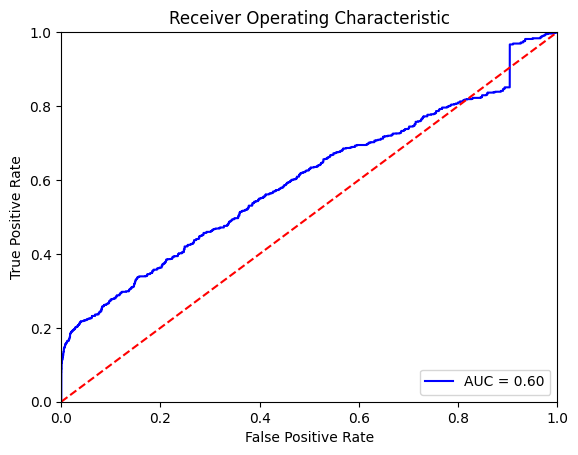

In [17]:
import sklearn.metrics as metrics

y_pred = []
y_test = []
for m, g in gold_standard_dict.items():
    y_pred.append(matches.get(m, 0))
    y_test.append(g)
    
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [18]:
false_negatives = [m for m in gold_standard if m not in matches]

In [19]:
len(gold_standard)

2102

In [20]:
len(matches)

29766

In [21]:
false_negatives

[(4, 0, 4, 1),
 (4, 0, 4, 2),
 (4, 1, 4, 2),
 (7, 0, 7, 1),
 (7, 0, 7, 2),
 (7, 1, 7, 2),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 2, 0, 3),
 (3, 4, 3, 19),
 (4, 3, 4, 4),
 (7, 3, 7, 4),
 (0, 5, 0, 6),
 (2, 6, 2, 17),
 (0, 9, 0, 10),
 (0, 11, 0, 12),
 (0, 11, 0, 13),
 (0, 11, 0, 14),
 (0, 11, 0, 15),
 (0, 11, 0, 16),
 (0, 11, 0, 17),
 (0, 11, 0, 18),
 (0, 11, 0, 19),
 (0, 11, 0, 20),
 (0, 11, 0, 21),
 (0, 11, 0, 22),
 (0, 12, 0, 13),
 (0, 12, 0, 14),
 (0, 12, 0, 15),
 (0, 12, 0, 16),
 (0, 12, 0, 17),
 (0, 12, 0, 18),
 (0, 12, 0, 19),
 (0, 12, 0, 20),
 (0, 12, 0, 21),
 (0, 12, 0, 22),
 (0, 13, 0, 14),
 (0, 13, 0, 15),
 (0, 13, 0, 16),
 (0, 13, 0, 17),
 (0, 13, 0, 18),
 (0, 13, 0, 19),
 (0, 13, 0, 20),
 (0, 13, 0, 21),
 (0, 13, 0, 22),
 (0, 14, 0, 15),
 (0, 14, 0, 16),
 (0, 14, 0, 17),
 (0, 14, 0, 18),
 (0, 14, 0, 19),
 (0, 14, 0, 20),
 (0, 14, 0, 21),
 (0, 14, 0, 22),
 (0, 15, 0, 16),
 (0, 15, 0, 17),
 (0, 15, 0, 18),
 (0, 15, 0, 19),
 (0, 15, 0, 20),
 (0, 15, 0, 21),
 (0, 15, 0, 22),
 (0, 16